# References

Medical neural networks:
https://glassboxmedicine.com/

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

# Setup

### Install packages

In [7]:
# Install additional packages

!pip install tf_keras_vis

In [8]:
import os
import pathlib
import re
from glob import glob
import random
import time
import zipfile
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import islice, count

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad, RMSprop
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K # element-wise sigmoid
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Check GPU and CPU instances

In [9]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Check which GPU is assigned to the session
!nvidia-smi

Mon Apr 25 03:03:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set seeds and mount Google Drive

In [11]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to Google Drive
base_path = '/content/drive/My Drive/ColabNotebooks/CSCI_109b/cs109b_final_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

### Load image data into TF datasets

In [13]:
# Get image filenames

# Path to images
images_path = base_path + 'images_rescaled_subsample'

# Filenames with full absolute paths
images_filenames_full_path = glob(images_path + '/*')

# Sort to be consistent
images_filenames_full_path.sort()

# Get terminal filenames
images_filenames = [re.sub('^(.*[/])', '', x) for x in images_filenames_full_path]

In [14]:
# Function to load the image data into TF datasets

def make_tf_image_dataset(filenames, image_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

  return images_ds

In [15]:
# Load the image and label data into TF datasets
# NOTE: this will load the grayscale image repeated 3 times (i.e., 3 channels)

IMG_SIZE = 256

images_ds = make_tf_image_dataset(filenames=images_filenames_full_path, image_size=IMG_SIZE)

print("images_ds shape: ", images_ds)
print("number of images parsed: ", images_ds.cardinality().numpy())

images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
number of images parsed:  1100


### Load label data into TF datasets

#### From "train_relabeled.csv" and "valid_relabeled.csv"

In [ ]:
# # Load label data from "train_relabeled.csv" and "valid_relabeled.csv"

# # Limit scope to 8 diseases in original paper
# columns_to_keep = ['Path', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

# # Load "train_relabeled.csv" and "valid_relabeled.csv"
# train_labels_df = pd.read_csv(google_drive_path + 'label_data/train_relabeled.csv')[columns_to_keep]
# valid_labels_df = pd.read_csv(google_drive_path + 'label_data/valid_relabeled.csv')[columns_to_keep]

# # Examine first 5 rows of training dataframe
# print(f'Shape of train_labels_df: {train_labels_df.shape}')
# display(train_labels_df.head())

# # Examine first 5 rows of validation dataframe
# print(f'Shape of valid_labels_df: {valid_labels_df.shape}')
# display(valid_labels_df.head())

# # Stack the two DataFrames
# labels_df = pd.concat([train_labels_df, valid_labels_df], ignore_index=True, axis=0)

# # Remove the 'images/' prefix from the Path column
# labels_df['Path'] = labels_df['Path'].apply(lambda x: re.sub('^(.*[/])', '', x))

# # Examine first 5 rows of combined dataframe
# print(f'Shape of labels_df: {labels_df.shape}')
# display(labels_df.head())

#### From "Data_Entry_2017_v2020.csv"

In [18]:
# Load Data_Entry_2017_v2020.csv

labels_path = base_path + 'meta_data/Data_Entry_2017_v2020.csv'
data_entry_df = pd.read_csv(labels_path)

# Examine first 5 rows of dataframe
print(f'Shape of data_entry_df: {data_entry_df.shape}')
display(data_entry_df.head())

Shape of data_entry_df: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [19]:
# Determine the number of unique label combinations
disease_combinations = data_entry_df['Finding Labels'].unique()
print(f'Number of unique disease combinations: {len(disease_combinations)}\n')

# Split up disease_combinations into individual diseases - get number of unique labels
disease_combinations_split = [combination.split('|') for combination in disease_combinations]
diseases = list(set([disease for observation in disease_combinations_split for disease in observation]))

# Sanity check - how many unique diseases are present in the data
print(f'Number of unique diseases (including No Finding): {len(diseases)}\n')
print('Unique diseases (including No Finding): \n')
for disease in diseases:
  print(disease)

Number of unique disease combinations: 836

Number of unique diseases (including No Finding): 15

Unique diseases (including No Finding): 

Edema
Effusion
Nodule
Consolidation
No Finding
Atelectasis
Fibrosis
Pneumothorax
Infiltration
Emphysema
Pleural_Thickening
Hernia
Cardiomegaly
Pneumonia
Mass


In [20]:
# One hot encode label data

# Rename image column
data_entry_df = data_entry_df.rename({'Image Index': 'image_filename'}, axis=1)

# Limit scope to 8 diseases in original paper plus 'No Finding'
diseases_to_keep = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
diseases = [disease for disease in diseases if disease in diseases_to_keep]

# Helper function to create one-hot encoded dataframe
@np.vectorize
def one_hot_disease(label, disease='No Finding'):
  if disease in label:
    return 1
  return 0

# Create one-hot encoded dataframe
one_hot_disease_df = data_entry_df[['image_filename']]
for disease in diseases:
  one_hot_disease_df[disease] = one_hot_disease(data_entry_df['Finding Labels'], disease=disease)

# Rename no finding column
one_hot_disease_df = one_hot_disease_df.rename({'No Finding': 'No_Finding'}, axis=1)

# Save results
one_hot_disease_df.to_csv(base_path + 'output/one_hot_data_entry.csv', index=False)

# Examine first 5 rows of one_hot_disease_df dataframe
print(f'Shape of one_hot_disease_df: {one_hot_disease_df.shape}')
display(one_hot_disease_df.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Shape of one_hot_disease_df: (112120, 10)


,image_filename,Effusion,Nodule,No_Finding,Atelectasis,Pneumothorax,Infiltration,Cardiomegaly,Pneumonia,Mass
0,00000001_000.png,0,0,0,0,0,0,1,0,0
1,00000001_001.png,0,0,0,0,0,0,1,0,0
2,00000001_002.png,1,0,0,0,0,0,1,0,0
3,00000002_000.png,0,0,1,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,0,0


In [21]:
# Subset labels_df to include only subsample

# Logically index labels_df based on subsample filenames
labels_subsample_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(images_filenames)]

# Reorder labels to match image order
labels_subsample_df = labels_subsample_df.sort_values('image_filename') 

# Examine first 5 rows of labels_subsample_df dataframe
print(f'Shape of labels_subsample_df: {labels_subsample_df.shape}')
display(labels_subsample_df.head())

Shape of labels_subsample_df: (1100, 10)


,image_filename,Effusion,Nodule,No_Finding,Atelectasis,Pneumothorax,Infiltration,Cardiomegaly,Pneumonia,Mass
151,00000032_037.png,0,0,0,0,0,1,1,0,0
310,00000072_000.png,0,0,0,1,0,0,0,0,0
596,00000147_001.png,0,0,0,1,0,0,0,0,0
608,00000149_006.png,0,0,0,1,0,0,0,0,0
614,00000150_002.png,0,0,0,1,0,1,0,1,0


In [22]:
# Convert labels to TF dataset

# Create label ds
labels_ds = tf.data.Dataset.from_tensor_slices(labels_subsample_df.drop(columns='image_filename'))   

print("labels_ds shape: ", labels_ds)
print("number of labels parsed: ", labels_ds.cardinality().numpy())   

labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(9,), dtype=tf.int64, name=None)>
number of labels parsed:  1100


### Combine images and labels

In [23]:
# Zip together the image and label data into one TF dataset

complete_ds = tf.data.Dataset.zip((images_ds, labels_ds))
complete_ds

<ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>

### Partition TF datasets into training and validation sets

In [24]:
# Function to partition the TF datasets into Training and Validation sets

def partition_tf_data(ds, ds_size, train_split=0.8, val_split=0.2, 
                      test_split=0, shuffle=True, shuffle_size=10000):
  
    # assert(train_split + test_split + val_split) == 1
    assert(train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=109)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds #, test_ds

In [25]:
# Partition the TF datasets

DS_SIZE = images_ds.cardinality().numpy()

train_ds, val_ds = partition_tf_data(ds=complete_ds, ds_size=DS_SIZE)

print("Train shape: ", train_ds)
print("Validation shape: ", val_ds)
print("number of training images/labels: ", train_ds.cardinality().numpy())
print("number of validation images/labels: ", val_ds.cardinality().numpy())

Train shape:  <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>
Validation shape:  <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>
number of training images/labels:  880
number of validation images/labels:  220


### Batching

In [26]:
# Set up batches

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 32

train_ds_batches = train_ds.shuffle(buffer_size=40000).batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=AUTOTUNE)
val_ds_batches = val_ds.batch(BATCH_SIZE_VAL).prefetch(buffer_size=AUTOTUNE)

print("Train shape: ", train_ds_batches)
print("Validation shape: ", val_ds_batches)

Train shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.int64, name=None))>
Validation shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.int64, name=None))>


### Preprocessing layers

In [27]:
# Pre-processing layers

# Rescale pixels
rescale_layer = Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

# Data augmentation
data_augmentation_layer = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2), 
  RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

# Model Training


### Callbacks

In [28]:
# Callbacks

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    min_delta=0.1, 
    patience=10, 
    restore_best_weights=True, 
    verbose=True)

# Reduce learning rate by factor of 0.5 if val_coef_determination does not improve within 3 epochs
reduce_lrt_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min',
    min_delta=0.2,
    factor=0.5,
    patience=3, 
    min_lr=1e-6,
    verbose=2)

# This function keeps the initial learning rate for the first 7 epochs and decreases it exponentially after that
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrt_scheduler = LearningRateScheduler(scheduler)

### Model architecture

Which model to use for transfer learning?

- ResNet (50, 18)
- VGG (16, 19)
- EfficientNet (B0, B1, B2, B3, B4, B5, B6, B7)

In [48]:
# Define model architecture

IMG_SIZE = 256

def create_model(transfer_model='ResNet50'):

  # Transfer models
  if transfer_model=='ResNet50':
      transfer_layer = ResNet50(include_top=False, weights='imagenet', 
                                input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='EfficientNetB2':
      transfer_layer = EfficientNetB2(include_top=False, weights="imagenet",
                                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG16':
      transfer_layer = VGG16(include_top=False, weights="imagenet",
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG19':
      transfer_layer = VGG19(include_top=False, weights="imagenet",
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
      
  # Inputs, Preprocessing, and Transfer layers
  inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  rescale = rescale_layer(inputs)
  augmented = data_augmentation_layer(rescale)
  transfer = transfer_layer(augmented)
  # TRY STUFF HERE

  # Pool for dense output
  pooling = GlobalAveragePooling2D()(transfer)
  dropout = Dropout(0.4)(pooling)
  # TRY STUFF HERE
  
  # Output layer
  outputs = Dense(9, activation='sigmoid')(dropout)  
  model = Model(inputs=inputs, outputs=outputs)
  return model

clear_session()
base_model = create_model(transfer_model='VGG19')
base_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0      

### Compile

In [49]:
# Compile

# Optimizers
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
base_model.compile(
    optimizer=opt, 
    loss='binary_crossentropy', 
    metrics=['AUC'])

### Train

In [50]:
# Train the model

# Parameters
EPOCHS = 50 

# Training
history = base_model.fit(
    x=train_ds_batches,  
    validation_data=val_ds_batches,
    epochs=EPOCHS,  
    verbose=1,
    use_multiprocessing=True, 
    callbacks=[early_stop, reduce_lrt_plateau, lrt_scheduler]
    )

%time

Epoch 1/50
28/28 [==============================] - 25s 616ms/step - loss: 12.4674 - auc: 0.5324 - val_loss: 0.4714 - val_auc: 0.5911 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 16s 462ms/step - loss: 0.4985 - auc: 0.5589 - val_loss: 0.4812 - val_auc: 0.6177 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 18s 537ms/step - loss: 0.5067 - auc: 0.5839 - val_loss: 1.0286 - val_auc: 0.5817 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.5218 - auc: 0.5779
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 16s 467ms/step - loss: 0.5218 - auc: 0.5779 - val_loss: 0.4822 - val_auc: 0.5979 - lr: 5.0000e-04
Epoch 5/50
28/28 [==============================] - 17s 507ms/step - loss: 0.4924 - auc: 0.5813 - val_loss: 0.4851 - val_auc: 0.5852 - lr: 5.0000e-04
Epoch 6/50
28/28 [==============================] - 19s 530ms/step - loss: 0.4889 - auc: 0.5926 - val_loss:

### Save / Load model

In [51]:
# Save model
base_model.save(base_path + 'output/base_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ColabNotebooks/CSCI_109b/cs109b_final_project/output/base_model/assets


In [ ]:
# Load model
base_model = load_model(base_path + 'output/base_model')

# Model Evaluation

### Plot history

In [36]:
def plot_history(model, title:str=''):
    """Create plots for the training history"""
    
    h = model.history.history
    y1 = h['auc']
    y2 = h['val_auc']
    y3 = h['loss']
    y4 = h['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    x = model.history.epoch
    ax1.plot(x, y1, label='train', linewidth=2)
    ax1.plot(x, y2, label='validation', linewidth=2)
    ax1.set_title('AUC-ROC', fontsize=20)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUC-ROC')
    best_auc = np.nanmax(y2)
    ax1.axvline(np.nanargmax(y2),
                ls='--', label=f'best val auc = {best_auc:.2f}')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(x, y3, label='train', linewidth=2)
    ax2.plot(x, y4, label='validation', linewidth=2)
    ax2.set_title('Loss', fontsize=20)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    best_loss = np.nanmin(y4)
    ax2.axvline(np.nanargmin(y4),
                ls='--', label=f'best val loss = {best_loss:.2f}')
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(title, fontsize=12)

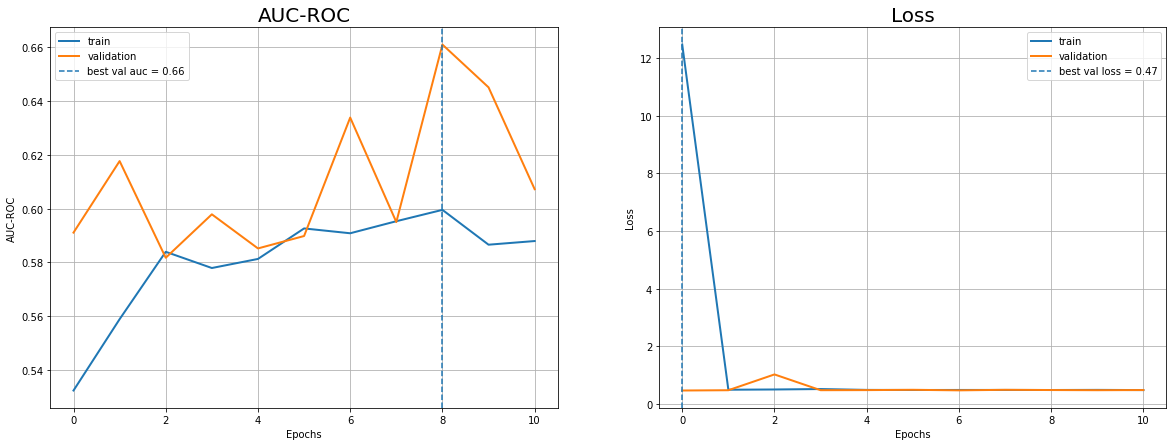

In [52]:
# Plot training loss
plot_history(base_model)

### Performance metrics

How to set up a confusion matrix from a prefetched TF dataset?

In [53]:
# Get classes from prefetched TF dataset

# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds_batches:  # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = base_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1)) #### SET UP FOR SOFTMAX

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [54]:
predicted_labels

<tf.Tensor: shape=(220,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>

In [55]:
correct_labels

<tf.Tensor: shape=(220, 9), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [ ]:
# Confusion matrix

# print('Confusion Matrix')
# print(confusion_matrix(correct_labels, predicted_labels))

In [ ]:
# Add functions for other performance metrics here


# Layer Visualizations

In [ ]:
# Add code for layer activation visualizations here
